In [ ]:
import zipfile
import os

zip_file_path = '/content/karmases.zip'  # ZIP dosyasının yolu
extracted_folder = '/content/karma'  # Çıkartılacak klasör

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Çıkartılan dosyaları kontrol edelim
extracted_files = os.listdir(extracted_folder)
print(f"ZIP dosyasından çıkarılan dosyalar: {extracted_files}")



ZIP dosyasından çıkarılan dosyalar: ['karmases', '__MACOSX']


In [ ]:
import os

base_dir = "/content/karma/karmases"
folders = ['blue', 'green', 'red', 'close', 'open']

# Her klasördeki .wav dosyalarını sayma
for folder in folders:
    folder_path = os.path.join(base_dir, folder)

    if os.path.exists(folder_path):
        wav_count = 0

        # Dosyaları sayma
        for filename in os.listdir(folder_path):
            if filename.endswith(".wav"):
                wav_count += 1

        print(f"{folder_path} klasöründe {wav_count} tane .wav dosyası var.")
    else:
        print(f"{folder_path} klasörü bulunamadı.")


/content/karma/karmases/blue klasöründe 424 tane .wav dosyası var.
/content/karma/karmases/green klasöründe 410 tane .wav dosyası var.
/content/karma/karmases/red klasöründe 410 tane .wav dosyası var.
/content/karma/karmases/close klasöründe 410 tane .wav dosyası var.
/content/karma/karmases/open klasöründe 410 tane .wav dosyası var.


Toplam 2064 dosya yüklendi.
Etiketler: {'open', 'red', 'green', 'blue', 'close'}
Etiket haritası başarıyla kaydedildi: label_mapping.json
Geçerli özellik sayısı: 2064
SMOTE sonrası eğitim verisi boyutu: (1695, 194)
Scaler başarıyla kaydedildi: svm_karma_scaler.joblib
Selector başarıyla kaydedildi: svm_selector.joblib
SVM Cross-Validation Doğruluk: 0.94 (+/- 0.02)
SVM Test Doğruluğu: 0.95


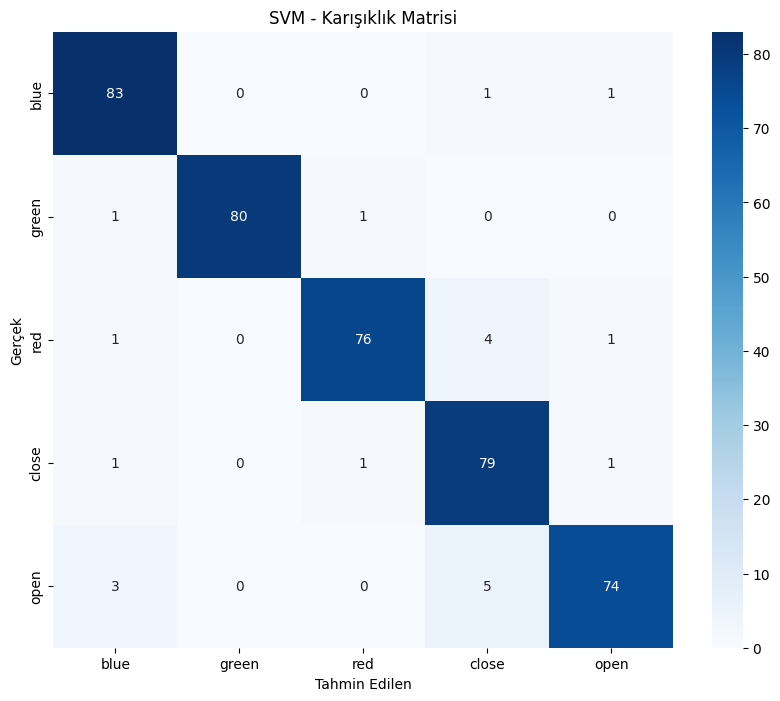

              precision    recall  f1-score   support

        blue       0.93      0.98      0.95        85
       green       1.00      0.98      0.99        82
         red       0.97      0.93      0.95        82
       close       0.89      0.96      0.92        82
        open       0.96      0.90      0.93        82

    accuracy                           0.95       413
   macro avg       0.95      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413

Model başarıyla kaydedildi: svm_model_karma_with_probabilities.joblib


In [ ]:
import os
import numpy as np
import librosa
import json
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

# Veri yolu
base_path = '/content/karma/karmases'

# İstediğiniz sınıflar
desired_classes = ['blue', 'green', 'red', 'close', 'open']

# Dosya yolları ve etiketleri toplama
file_paths, labels = [], []
for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    if os.path.isdir(class_path) and class_folder in desired_classes:
        for file_name in os.listdir(class_path):
            if file_name.endswith(".wav"):
                file_paths.append(os.path.join(class_path, file_name))
                labels.append(class_folder)

print(f"Toplam {len(file_paths)} dosya yüklendi.")
print(f"Etiketler: {set(labels)}")

# Özellik çıkarma fonksiyonu
def extract_rich_audio_features(file_path, n_mfcc=30, max_pad_len=100):
    """Ses dosyasından MFCC ve diğer özellikleri çıkarır."""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        delta_mfcc = librosa.feature.delta(mfccs)
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

        features = np.concatenate([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(delta_mfcc, axis=1), np.std(delta_mfcc, axis=1),
            np.mean(delta2_mfcc, axis=1), np.std(delta2_mfcc, axis=1),
            np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1)
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Özellik çıkarma
features, labels_numeric = [], []
label_mapping = {label: idx for idx, label in enumerate(desired_classes)}

# Etiket haritasını kaydetme
with open("label_mapping.json", "w", encoding="utf-8") as f:
    json.dump(label_mapping, f, ensure_ascii=False)
print("Etiket haritası başarıyla kaydedildi: label_mapping.json")

for file, label in zip(file_paths, labels):
    feature = extract_rich_audio_features(file, n_mfcc=30, max_pad_len=100)
    if feature is not None:
        features.append(feature)
        labels_numeric.append(label_mapping[label])

print(f"Geçerli özellik sayısı: {len(features)}")

# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(
    np.array(features),
    np.array(labels_numeric),
    test_size=0.2,
    stratify=labels_numeric,
    random_state=42
)

# SMOTE ile veri dengesizliğini giderme
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"SMOTE sonrası eğitim verisi boyutu: {X_train.shape}")

# Standardizasyon
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scaler'ı kaydetme
dump(scaler, "svm_karma_scaler.joblib")
print("Scaler başarıyla kaydedildi: svm_karma_scaler.joblib")

# Özellik seçimi
selector = SelectKBest(score_func=f_classif, k=min(1000, X_train.shape[1]))
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Selector'ı kaydetme
dump(selector, "svm_selector.joblib")
print("Selector başarıyla kaydedildi: svm_selector.joblib")

# SVM modeli (probability=True ile olasılık tahmini)
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Bu parametreyi ekliyoruz
    random_state=42
)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"SVM Cross-Validation Doğruluk: {np.mean(svm_cv_scores):.2f} (+/- {np.std(svm_cv_scores):.2f})")

# Modeli eğitme
svm_model.fit(X_train, y_train)

# Modelin doğruluğunu değerlendirme
svm_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Test Doğruluğu: {svm_accuracy:.2f}")

# Karışıklık matrisi
y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("SVM - Karışıklık Matrisi")
plt.show()

# Sınıflandırma raporu
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# Modeli kaydetme
dump(svm_model, "svm_model_karma_with_probabilities.joblib")
print("Model başarıyla kaydedildi: svm_model_karma_with_probabilities.joblib")


In [ ]:
import zipfile
import os

zip_file_path = '/content/sestest.zip'  # ZIP dosyasının yolu
extracted_folder = '/content/TEST'  # Çıkartılacak klasör

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Çıkartılan dosyaları kontrol edelim
extracted_files = os.listdir(extracted_folder)
print(f"ZIP dosyasından çıkarılan dosyalar: {extracted_files}")



ZIP dosyasından çıkarılan dosyalar: ['__MACOSX', 'sestest']


In [ ]:
import numpy as np
import librosa
import json
from joblib import load
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

# Etiket haritasını yükle
with open('/content/label_mapping.json', 'r', encoding='utf-8') as f:
    label_mapping = json.load(f)

# Model ve ön işleme nesnelerini yükle
svm_model = load('/content/svm_model_karma_with_probabilities.joblib')
scaler = load('/content/svm_karma_scaler.joblib')
selector = load('/content/svm_selector.joblib')

# Özellik çıkarma fonksiyonu
def extract_rich_audio_features(file_path, n_mfcc=30, max_pad_len=100):
    """Ses dosyasından MFCC ve diğer özellikleri çıkarır."""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        delta_mfcc = librosa.feature.delta(mfccs)
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

        features = np.concatenate([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(delta_mfcc, axis=1), np.std(delta_mfcc, axis=1),
            np.mean(delta2_mfcc, axis=1), np.std(delta2_mfcc, axis=1),
            np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1)
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Yeni ses kaydında tahmin yapma
def predict_class(file_path):
    feature = extract_rich_audio_features(file_path, n_mfcc=30, max_pad_len=100)
    if feature is not None:
        # Özellikleri standardize et
        feature = scaler.transform([feature])

        # Özellik seçimi uygula
        feature = selector.transform(feature)

        # Decision function kullanarak tahmin yap
        decision_scores = svm_model.decision_function(feature)  # Decision function skoru
        predicted_class_index = np.argmax(decision_scores)

        # Etiket haritasına göre sınıf adı
        predicted_class = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class_index)]
        predicted_score = decision_scores[0][predicted_class_index]  # Skor değeri

        # Tahminin olasılığını %100'e dönüştür
        prediction_probability = 100 * (1 / (1 + np.exp(-predicted_score)))  # Sigmoid fonksiyonu ile dönüşüm
        print(f"{file_path}: {predicted_class} sınıfına % {prediction_probability:.2f} olasılıkla aittir.")
        return predicted_class, prediction_probability
    else:
        print(f"Özellik çıkarılamadı: {file_path}")
        return None, None

# Ses dosyalarının bulunduğu klasörü belirtin
audio_folder = '/content/TEST/sestest'

# Klasördeki tüm .wav dosyalarını al
test_audio_paths = [os.path.join(audio_folder, filename) for filename in os.listdir(audio_folder) if filename.endswith(".wav")]

# 5 ses kaydını tahmin et
for audio_path in test_audio_paths:
    predict_class(audio_path)

/content/TEST/sestest/time_stretched_normalized_closemale.wav: close sınıfına % 98.58 olasılıkla aittir.
/content/TEST/sestest/nesli-kapa1.wav: close sınıfına % 98.62 olasılıkla aittir.
/content/TEST/sestest/ac╠º03_JKMN_Erkek_XGATER.wav: open sınıfına % 98.64 olasılıkla aittir.
/content/TEST/sestest/reverb_normalized_nesli-kapa.wav: close sınıfına % 98.62 olasılıkla aittir.
/content/TEST/sestest/denoised_openwrain.wav: open sınıfına % 98.62 olasılıkla aittir.
/content/TEST/sestest/nesli-ac╠º2.wav: open sınıfına % 98.62 olasılıkla aittir.
/content/TEST/sestest/yesil_klima_ardil.wav: green sınıfına % 98.63 olasılıkla aittir.
/content/TEST/sestest/pitch_time_normalized_greennberra.wav: green sınıfına % 98.56 olasılıkla aittir.
/content/TEST/sestest/kapa01_FDNK_Erkek_ENFLPO.wav: close sınıfına % 98.63 olasılıkla aittir.
/content/TEST/sestest/mavi02_BRKB_Erkek_JJZQHL.wav: blue sınıfına % 98.62 olasılıkla aittir.
/content/TEST/sestest/mavi_yagmur_fisilti_ardil.wav: blue sınıfına % 98.62 olas